## Load Python Modules

In [1]:
import numpy as np 
import pandas as pd 
from skimage import filters
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os
from image import *
from CNN import *
import util
%load_ext autoreload
%autoreload 2

## Show NVIDIA GPU

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-a834fce4-9456-6c32-43bc-8d8574de0b1f)


## Setup Utility

In [3]:
util.setup_logger()

# Load and Process Dataset

## Load Dataset

In [25]:
folder_path = os.path.join(os.getenv("HOME"), "scratch")
dataset = ImageDataset(os.path.join(folder_path, "train_80p.csv"), use_augmentation=False, model="CNN", fft=True)

## Check Dataset

In [59]:
dataset.check()

There are 0 missing values
39975 images with label 0, and 39975 with label 1.
All filenames end with .jpg


## (Optional) Show image for verification

Label: 0, shape: torch.Size([3, 480, 768])


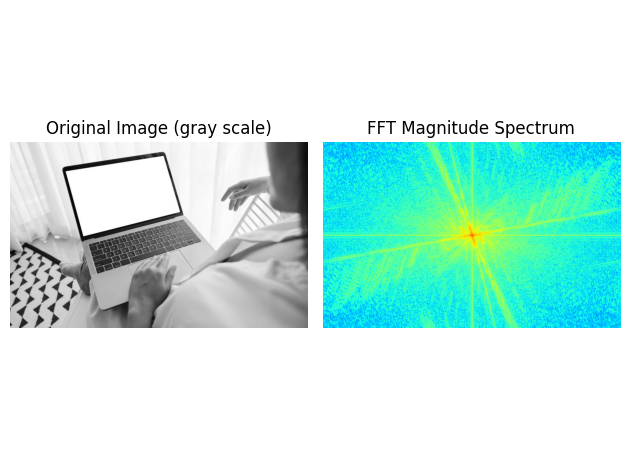

Label: 1, shape: torch.Size([3, 512, 768])


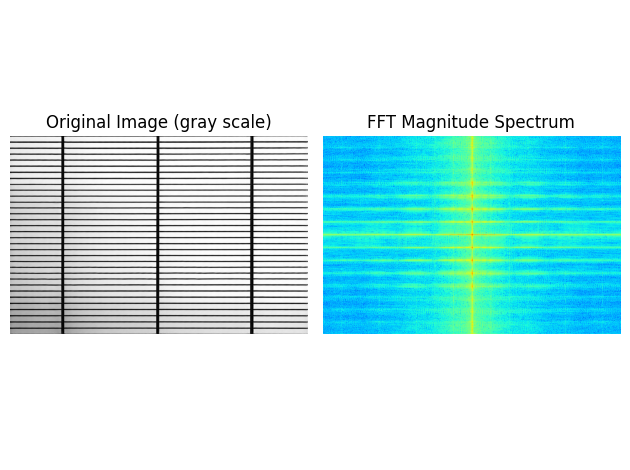

In [60]:
dataset.show_image(fft=True)

## (Optional) Show normalized images

Label: 0, shape: torch.Size([3, 100, 100])
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


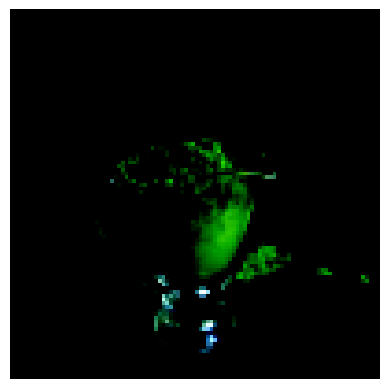

Label: 1, shape: torch.Size([3, 100, 100])
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


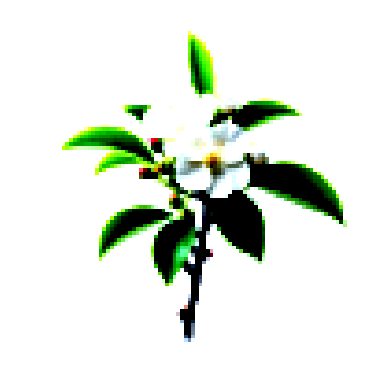

In [19]:
dataset.show_image(transform=True)

# FFT

[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3866258..1.7200577].


(np.float64(-0.5), np.float64(767.5), np.float64(511.5), np.float64(-0.5))

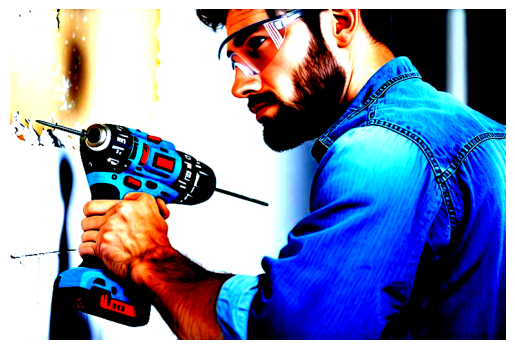

In [46]:
img, label = dataset[10]
img = np.transpose(img, (1, 2, 0))
# img = np.array(img)
img = img.numpy()
plt.imshow(img)
plt.axis('off')

In [34]:
r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
gray_img = 0.299 * r + 0.587 * g + 0.114 * b

In [35]:
fft = np.fft.fft2(gray_img)
fft_shifted = np.fft.fftshift(fft)
magnitude_spectrum = 20 * np.log(np.abs(fft_shifted) + 1e-5)

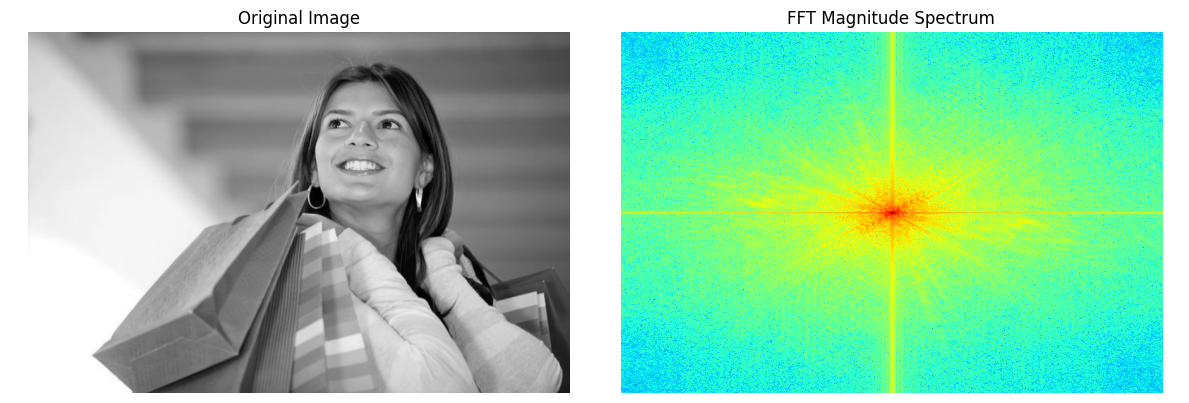

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.axis("off")

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(gray_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap="jet")
plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
magnitude_spectrum.shape
magnitude_spectrum.flatten().shape

(393216,)

## Create Torch Data Loaders

In [27]:
batch_size = 64
loader = dataset.get_loader(shuffle=False, batch_size=batch_size)

## Check CUDA Availability

In [18]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# t-SNE

In [35]:
n_components=2
tsne = TSNE(n_components=n_components, perplexity=30, max_iter=300, random_state=1001)
num_batch = 10
X_tsne = np.zeros((num_batch*batch_size, n_components))
Y = np.zeros(num_batch*batch_size)
for batch_idx, (images, labels) in enumerate(loader):
    if batch_idx >= num_batch: break
    X_tmp = tsne.fit_transform(images)
    X_tsne[batch_size*batch_idx:batch_size*(batch_idx+1), :] = X_tmp
    Y[batch_size*batch_idx:batch_size*(batch_idx+1)] = labels.numpy()

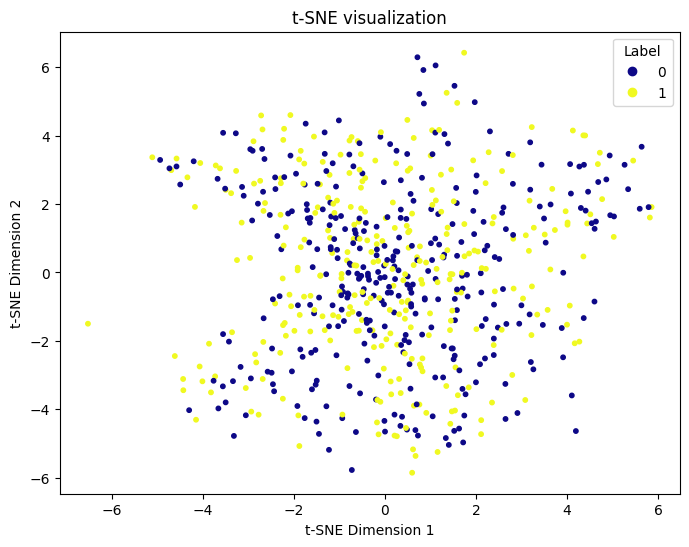

In [50]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='plasma', s=10)
plt.title(f"t-SNE visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(*scatter.legend_elements(), title="Label")
plt.show()

# Flatten Image for PCA

In [27]:
all_images = []
all_labels = []

for batch_idx, (images, labels) in enumerate(loader):
    images = images.to(device)
    
    labels = labels.to(device)

    edge_detected_images = []

    for i in range(3):  
        channel = images[:, i, :, :]  

        sobel_edges = filters.sobel(channel.cpu().numpy())  
        
        sobel_edges = torch.tensor(sobel_edges).to(device) 
        
        edge_detected_images.append(sobel_edges)

    edge_detected_images = torch.stack(edge_detected_images, dim=1)
    
    batch_flat = edge_detected_images.view(edge_detected_images.size(0), -1)

    batch_flat_cpu = batch_flat.cpu().numpy()

    all_images.append(batch_flat_cpu)
    all_labels.append(labels.cpu().numpy()) 

numpy_images = np.vstack(all_images) 
numpy_labels = np.concatenate(all_labels) 

Processing batch 1
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 2
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 3
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 4
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 5
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU:

Processing batch 40
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 41
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 42
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 43
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 44
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to

Processing batch 79
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 80
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 81
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 82
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 83
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to

Processing batch 118
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 119
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 120
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 121
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 122
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 156
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 157
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 158
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 159
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 160
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 194
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 195
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 196
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 197
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 198
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 232
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 233
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 234
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 235
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 236
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 270
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 271
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 272
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 273
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 274
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 308
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 309
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 310
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 311
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 312
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 346
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 347
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 348
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 349
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 350
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 384
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 385
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 386
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 387
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 388
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 422
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 423
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 424
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 425
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 426
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 460
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 461
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 462
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 463
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 464
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 498
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 499
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 500
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 501
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 502
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 536
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 537
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 538
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 539
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 540
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 574
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 575
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 576
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 577
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 578
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 612
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 613
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 614
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 615
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 616
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 650
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 651
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 652
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 653
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 654
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 688
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 689
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 690
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 691
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 692
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 726
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 727
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 728
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 729
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 730
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 764
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 765
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 766
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 767
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 768
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 802
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 803
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 804
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 805
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 806
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 840
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 841
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 842
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 843
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 844
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 878
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 879
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 880
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 881
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 882
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 916
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 917
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 918
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 919
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 920
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 954
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 955
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 956
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 957
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 958
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 992
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 993
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 994
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 995
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 996
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before movi

Processing batch 1030
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1031
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1032
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1033
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1034
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

Processing batch 1068
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1069
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1070
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1071
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1072
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

Processing batch 1106
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1107
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1108
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1109
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1110
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

Processing batch 1144
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1145
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1146
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1147
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1148
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

Processing batch 1182
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1183
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1184
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1185
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1186
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

Processing batch 1220
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1221
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1222
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1223
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before moving to CPU: torch.Size([64, 30000])
Shape of flattened batch on CPU: (64, 30000)
Processing batch 1224
Shape of edge-detected images before flattening: torch.Size([64, 3, 100, 100])
Shape of flattened batch before

# Apply PCA

In [ ]:
dimensionality_reduction = 2

loaded_images = np.load(images_file_path)
loaded_labels = np.load(labels_file_path)

pca = PCA(n_components=dimensionality_reduction)
X_pca = pca.fit_transform(loaded_images)